# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Normalize
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Hyperparameters

In [7]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs =1000

n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

In [9]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 18)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 18) --> (batch, 16, 36)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 36) --> (batch, 8, 36)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Build the inception layer:

![title](img/HAR_inception.png)

In [10]:
with graph.as_default():
    
    # convolution: input to output of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_11 = tf.layers.conv1d(inputs=max_pool_4, filters=36, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_21 = tf.layers.conv1d(inputs=max_pool_4, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_31 = tf.layers.conv1d(inputs=max_pool_4, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # average pool: input to middle layer of inception
    # (batch, 8, 36) --> (batch, 8, 36)
    avg_pool_41 = tf.layers.average_pooling1d(inputs=max_pool_4, pool_size=2, strides=1, padding='same')
    
    ## Middle layer of inception
    
    # convolution: middle to out layer of inception (size=2)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv2_22 = tf.layers.conv1d(inputs=conv1_21, filters=36, kernel_size=2, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=4)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv4_32 = tf.layers.conv1d(inputs=conv1_31, filters=36, kernel_size=4, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_42 = tf.layers.conv1d(inputs=avg_pool_41, filters=36, kernel_size=1, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    ## Out layer: Concatenate filters
    # (batch, 8, 4*36)
    inception_out = tf.concat([conv1_11, conv2_22, conv4_32, conv1_42], axis=2)

Now, flatten and pass to the classifier

In [11]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(inception_out, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [12]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [ ]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.864758 Train acc: 0.191667
Epoch: 1/1000 Iteration: 10 Train loss: 1.823035 Train acc: 0.175000
Epoch: 1/1000 Iteration: 10 Validation loss: 1.810274 Validation acc: 0.246667
Epoch: 1/1000 Iteration: 15 Train loss: 1.805057 Train acc: 0.176667
Epoch: 2/1000 Iteration: 20 Train loss: 1.764323 Train acc: 0.233333
Epoch: 2/1000 Iteration: 20 Validation loss: 1.753492 Validation acc: 0.291667
Epoch: 2/1000 Iteration: 25 Train loss: 1.749063 Train acc: 0.225000
Epoch: 3/1000 Iteration: 30 Train loss: 1.731421 Train acc: 0.236667
Epoch: 3/1000 Iteration: 30 Validation loss: 1.708220 Validation acc: 0.303333
Epoch: 3/1000 Iteration: 35 Train loss: 1.699471 Train acc: 0.221667
Epoch: 4/1000 Iteration: 40 Train loss: 1.684819 Train acc: 0.223333
Epoch: 4/1000 Iteration: 40 Validation loss: 1.668651 Validation acc: 0.317222
Epoch: 4/1000 Iteration: 45 Train loss: 1.680932 Train acc: 0.263333
Epoch: 5/1000 Iteration: 50 Train loss: 1.655293 Train acc: 0.25

Epoch: 42/1000 Iteration: 385 Train loss: 0.234017 Train acc: 0.920000
Epoch: 43/1000 Iteration: 390 Train loss: 0.269510 Train acc: 0.910000
Epoch: 43/1000 Iteration: 390 Validation loss: 0.212435 Validation acc: 0.918889
Epoch: 43/1000 Iteration: 395 Train loss: 0.212822 Train acc: 0.935000
Epoch: 44/1000 Iteration: 400 Train loss: 0.235051 Train acc: 0.915000
Epoch: 44/1000 Iteration: 400 Validation loss: 0.203489 Validation acc: 0.925000
Epoch: 44/1000 Iteration: 405 Train loss: 0.259670 Train acc: 0.915000
Epoch: 45/1000 Iteration: 410 Train loss: 0.216609 Train acc: 0.923333
Epoch: 45/1000 Iteration: 410 Validation loss: 0.195195 Validation acc: 0.926111
Epoch: 46/1000 Iteration: 415 Train loss: 0.207670 Train acc: 0.933333
Epoch: 46/1000 Iteration: 420 Train loss: 0.204300 Train acc: 0.928333
Epoch: 46/1000 Iteration: 420 Validation loss: 0.187962 Validation acc: 0.928333
Epoch: 47/1000 Iteration: 425 Train loss: 0.205426 Train acc: 0.931667
Epoch: 47/1000 Iteration: 430 Train l

Epoch: 83/1000 Iteration: 755 Train loss: 0.099678 Train acc: 0.960000
Epoch: 84/1000 Iteration: 760 Train loss: 0.150725 Train acc: 0.926667
Epoch: 84/1000 Iteration: 760 Validation loss: 0.126327 Validation acc: 0.942778
Epoch: 84/1000 Iteration: 765 Train loss: 0.140401 Train acc: 0.956667
Epoch: 85/1000 Iteration: 770 Train loss: 0.121567 Train acc: 0.950000
Epoch: 85/1000 Iteration: 770 Validation loss: 0.126067 Validation acc: 0.945556
Epoch: 86/1000 Iteration: 775 Train loss: 0.116244 Train acc: 0.951667
Epoch: 86/1000 Iteration: 780 Train loss: 0.113017 Train acc: 0.945000
Epoch: 86/1000 Iteration: 780 Validation loss: 0.125287 Validation acc: 0.943889
Epoch: 87/1000 Iteration: 785 Train loss: 0.124554 Train acc: 0.958333
Epoch: 87/1000 Iteration: 790 Train loss: 0.118966 Train acc: 0.953333
Epoch: 87/1000 Iteration: 790 Validation loss: 0.124512 Validation acc: 0.944444
Epoch: 88/1000 Iteration: 795 Train loss: 0.143078 Train acc: 0.928333
Epoch: 88/1000 Iteration: 800 Train l

Epoch: 124/1000 Iteration: 1120 Validation loss: 0.114362 Validation acc: 0.949444
Epoch: 124/1000 Iteration: 1125 Train loss: 0.121828 Train acc: 0.958333
Epoch: 125/1000 Iteration: 1130 Train loss: 0.102703 Train acc: 0.956667
Epoch: 125/1000 Iteration: 1130 Validation loss: 0.114011 Validation acc: 0.949444
Epoch: 126/1000 Iteration: 1135 Train loss: 0.098391 Train acc: 0.965000
Epoch: 126/1000 Iteration: 1140 Train loss: 0.106342 Train acc: 0.953333
Epoch: 126/1000 Iteration: 1140 Validation loss: 0.113866 Validation acc: 0.949444
Epoch: 127/1000 Iteration: 1145 Train loss: 0.113597 Train acc: 0.958333
Epoch: 127/1000 Iteration: 1150 Train loss: 0.108160 Train acc: 0.958333
Epoch: 127/1000 Iteration: 1150 Validation loss: 0.114089 Validation acc: 0.948333
Epoch: 128/1000 Iteration: 1155 Train loss: 0.128550 Train acc: 0.938333
Epoch: 128/1000 Iteration: 1160 Train loss: 0.085508 Train acc: 0.963333
Epoch: 128/1000 Iteration: 1160 Validation loss: 0.113666 Validation acc: 0.949444
E

Epoch: 165/1000 Iteration: 1490 Train loss: 0.090966 Train acc: 0.963333
Epoch: 165/1000 Iteration: 1490 Validation loss: 0.107539 Validation acc: 0.950000
Epoch: 166/1000 Iteration: 1495 Train loss: 0.091826 Train acc: 0.960000
Epoch: 166/1000 Iteration: 1500 Train loss: 0.088399 Train acc: 0.955000
Epoch: 166/1000 Iteration: 1500 Validation loss: 0.107219 Validation acc: 0.950000
Epoch: 167/1000 Iteration: 1505 Train loss: 0.097243 Train acc: 0.961667
Epoch: 167/1000 Iteration: 1510 Train loss: 0.104625 Train acc: 0.963333
Epoch: 167/1000 Iteration: 1510 Validation loss: 0.107019 Validation acc: 0.950556
Epoch: 168/1000 Iteration: 1515 Train loss: 0.124405 Train acc: 0.936667
Epoch: 168/1000 Iteration: 1520 Train loss: 0.074070 Train acc: 0.971667
Epoch: 168/1000 Iteration: 1520 Validation loss: 0.106715 Validation acc: 0.950000
Epoch: 169/1000 Iteration: 1525 Train loss: 0.124207 Train acc: 0.935000
Epoch: 169/1000 Iteration: 1530 Train loss: 0.114137 Train acc: 0.960000
Epoch: 169/

Epoch: 207/1000 Iteration: 1865 Train loss: 0.093525 Train acc: 0.965000
Epoch: 207/1000 Iteration: 1870 Train loss: 0.092810 Train acc: 0.968333
Epoch: 207/1000 Iteration: 1870 Validation loss: 0.100238 Validation acc: 0.950000
Epoch: 208/1000 Iteration: 1875 Train loss: 0.104894 Train acc: 0.946667
Epoch: 208/1000 Iteration: 1880 Train loss: 0.067127 Train acc: 0.970000
Epoch: 208/1000 Iteration: 1880 Validation loss: 0.100309 Validation acc: 0.951111
Epoch: 209/1000 Iteration: 1885 Train loss: 0.116753 Train acc: 0.941667
Epoch: 209/1000 Iteration: 1890 Train loss: 0.103405 Train acc: 0.955000
Epoch: 209/1000 Iteration: 1890 Validation loss: 0.099921 Validation acc: 0.952222
Epoch: 210/1000 Iteration: 1895 Train loss: 0.092784 Train acc: 0.958333
Epoch: 211/1000 Iteration: 1900 Train loss: 0.078819 Train acc: 0.970000
Epoch: 211/1000 Iteration: 1900 Validation loss: 0.100022 Validation acc: 0.952778
Epoch: 211/1000 Iteration: 1905 Train loss: 0.079487 Train acc: 0.963333
Epoch: 212/

Epoch: 247/1000 Iteration: 2225 Train loss: 0.083877 Train acc: 0.961667
Epoch: 247/1000 Iteration: 2230 Train loss: 0.083816 Train acc: 0.958333
Epoch: 247/1000 Iteration: 2230 Validation loss: 0.094717 Validation acc: 0.957222
Epoch: 248/1000 Iteration: 2235 Train loss: 0.103102 Train acc: 0.941667
Epoch: 248/1000 Iteration: 2240 Train loss: 0.065096 Train acc: 0.975000
Epoch: 248/1000 Iteration: 2240 Validation loss: 0.094179 Validation acc: 0.957222
Epoch: 249/1000 Iteration: 2245 Train loss: 0.111620 Train acc: 0.938333
Epoch: 249/1000 Iteration: 2250 Train loss: 0.091729 Train acc: 0.961667
Epoch: 249/1000 Iteration: 2250 Validation loss: 0.094198 Validation acc: 0.957778
Epoch: 250/1000 Iteration: 2255 Train loss: 0.083423 Train acc: 0.966667
Epoch: 251/1000 Iteration: 2260 Train loss: 0.069448 Train acc: 0.970000
Epoch: 251/1000 Iteration: 2260 Validation loss: 0.094164 Validation acc: 0.957222
Epoch: 251/1000 Iteration: 2265 Train loss: 0.071153 Train acc: 0.963333
Epoch: 252/

Epoch: 287/1000 Iteration: 2590 Train loss: 0.077361 Train acc: 0.965000
Epoch: 287/1000 Iteration: 2590 Validation loss: 0.089535 Validation acc: 0.961111
Epoch: 288/1000 Iteration: 2595 Train loss: 0.091514 Train acc: 0.956667
Epoch: 288/1000 Iteration: 2600 Train loss: 0.052096 Train acc: 0.983333
Epoch: 288/1000 Iteration: 2600 Validation loss: 0.089897 Validation acc: 0.962778
Epoch: 289/1000 Iteration: 2605 Train loss: 0.096492 Train acc: 0.951667
Epoch: 289/1000 Iteration: 2610 Train loss: 0.090268 Train acc: 0.960000
Epoch: 289/1000 Iteration: 2610 Validation loss: 0.089337 Validation acc: 0.961667
Epoch: 290/1000 Iteration: 2615 Train loss: 0.072419 Train acc: 0.970000
Epoch: 291/1000 Iteration: 2620 Train loss: 0.066711 Train acc: 0.976667
Epoch: 291/1000 Iteration: 2620 Validation loss: 0.089117 Validation acc: 0.962222
Epoch: 291/1000 Iteration: 2625 Train loss: 0.067144 Train acc: 0.968333
Epoch: 292/1000 Iteration: 2630 Train loss: 0.073291 Train acc: 0.966667
Epoch: 292/

Epoch: 328/1000 Iteration: 2955 Train loss: 0.083543 Train acc: 0.956667
Epoch: 328/1000 Iteration: 2960 Train loss: 0.041748 Train acc: 0.980000
Epoch: 328/1000 Iteration: 2960 Validation loss: 0.085256 Validation acc: 0.961667
Epoch: 329/1000 Iteration: 2965 Train loss: 0.080917 Train acc: 0.960000
Epoch: 329/1000 Iteration: 2970 Train loss: 0.083036 Train acc: 0.963333
Epoch: 329/1000 Iteration: 2970 Validation loss: 0.086084 Validation acc: 0.960556
Epoch: 330/1000 Iteration: 2975 Train loss: 0.062384 Train acc: 0.971667
Epoch: 331/1000 Iteration: 2980 Train loss: 0.057588 Train acc: 0.978333
Epoch: 331/1000 Iteration: 2980 Validation loss: 0.085616 Validation acc: 0.960556
Epoch: 331/1000 Iteration: 2985 Train loss: 0.060171 Train acc: 0.971667
Epoch: 332/1000 Iteration: 2990 Train loss: 0.064520 Train acc: 0.973333
Epoch: 332/1000 Iteration: 2990 Validation loss: 0.086032 Validation acc: 0.961667
Epoch: 332/1000 Iteration: 2995 Train loss: 0.066688 Train acc: 0.973333
Epoch: 333/

Epoch: 368/1000 Iteration: 3320 Train loss: 0.039599 Train acc: 0.986667
Epoch: 368/1000 Iteration: 3320 Validation loss: 0.082587 Validation acc: 0.963889
Epoch: 369/1000 Iteration: 3325 Train loss: 0.072234 Train acc: 0.965000
Epoch: 369/1000 Iteration: 3330 Train loss: 0.070696 Train acc: 0.966667
Epoch: 369/1000 Iteration: 3330 Validation loss: 0.083914 Validation acc: 0.963333
Epoch: 370/1000 Iteration: 3335 Train loss: 0.058600 Train acc: 0.975000
Epoch: 371/1000 Iteration: 3340 Train loss: 0.053517 Train acc: 0.973333
Epoch: 371/1000 Iteration: 3340 Validation loss: 0.082842 Validation acc: 0.962778
Epoch: 371/1000 Iteration: 3345 Train loss: 0.052844 Train acc: 0.980000
Epoch: 372/1000 Iteration: 3350 Train loss: 0.051821 Train acc: 0.980000
Epoch: 372/1000 Iteration: 3350 Validation loss: 0.081937 Validation acc: 0.965000
Epoch: 372/1000 Iteration: 3355 Train loss: 0.051720 Train acc: 0.975000
Epoch: 373/1000 Iteration: 3360 Train loss: 0.071402 Train acc: 0.968333
Epoch: 373/

Epoch: 409/1000 Iteration: 3685 Train loss: 0.062363 Train acc: 0.976667
Epoch: 409/1000 Iteration: 3690 Train loss: 0.058738 Train acc: 0.965000
Epoch: 409/1000 Iteration: 3690 Validation loss: 0.081873 Validation acc: 0.965556
Epoch: 410/1000 Iteration: 3695 Train loss: 0.054811 Train acc: 0.976667
Epoch: 411/1000 Iteration: 3700 Train loss: 0.042127 Train acc: 0.983333
Epoch: 411/1000 Iteration: 3700 Validation loss: 0.083882 Validation acc: 0.964444
Epoch: 411/1000 Iteration: 3705 Train loss: 0.043918 Train acc: 0.983333
Epoch: 412/1000 Iteration: 3710 Train loss: 0.041883 Train acc: 0.981667
Epoch: 412/1000 Iteration: 3710 Validation loss: 0.083007 Validation acc: 0.966667
Epoch: 412/1000 Iteration: 3715 Train loss: 0.039902 Train acc: 0.981667
Epoch: 413/1000 Iteration: 3720 Train loss: 0.059042 Train acc: 0.975000
Epoch: 413/1000 Iteration: 3720 Validation loss: 0.083957 Validation acc: 0.968889
Epoch: 413/1000 Iteration: 3725 Train loss: 0.031314 Train acc: 0.988333
Epoch: 414/

Epoch: 449/1000 Iteration: 4045 Train loss: 0.049106 Train acc: 0.981667
Epoch: 449/1000 Iteration: 4050 Train loss: 0.045698 Train acc: 0.973333
Epoch: 449/1000 Iteration: 4050 Validation loss: 0.081893 Validation acc: 0.971111
Epoch: 450/1000 Iteration: 4055 Train loss: 0.049581 Train acc: 0.976667
Epoch: 451/1000 Iteration: 4060 Train loss: 0.039455 Train acc: 0.986667
Epoch: 451/1000 Iteration: 4060 Validation loss: 0.080664 Validation acc: 0.968889
Epoch: 451/1000 Iteration: 4065 Train loss: 0.045449 Train acc: 0.985000
Epoch: 452/1000 Iteration: 4070 Train loss: 0.039111 Train acc: 0.981667
Epoch: 452/1000 Iteration: 4070 Validation loss: 0.080087 Validation acc: 0.970556
Epoch: 452/1000 Iteration: 4075 Train loss: 0.029215 Train acc: 0.991667
Epoch: 453/1000 Iteration: 4080 Train loss: 0.043178 Train acc: 0.983333
Epoch: 453/1000 Iteration: 4080 Validation loss: 0.080424 Validation acc: 0.971667
Epoch: 453/1000 Iteration: 4085 Train loss: 0.022366 Train acc: 0.993333
Epoch: 454/

Epoch: 490/1000 Iteration: 4415 Train loss: 0.033126 Train acc: 0.983333
Epoch: 491/1000 Iteration: 4420 Train loss: 0.029622 Train acc: 0.996667
Epoch: 491/1000 Iteration: 4420 Validation loss: 0.080432 Validation acc: 0.975556
Epoch: 491/1000 Iteration: 4425 Train loss: 0.032139 Train acc: 0.993333
Epoch: 492/1000 Iteration: 4430 Train loss: 0.025063 Train acc: 0.991667
Epoch: 492/1000 Iteration: 4430 Validation loss: 0.078661 Validation acc: 0.977222
Epoch: 492/1000 Iteration: 4435 Train loss: 0.028152 Train acc: 0.993333
Epoch: 493/1000 Iteration: 4440 Train loss: 0.039890 Train acc: 0.980000
Epoch: 493/1000 Iteration: 4440 Validation loss: 0.080033 Validation acc: 0.975000
Epoch: 493/1000 Iteration: 4445 Train loss: 0.022479 Train acc: 0.990000
Epoch: 494/1000 Iteration: 4450 Train loss: 0.041717 Train acc: 0.985000
Epoch: 494/1000 Iteration: 4450 Validation loss: 0.084726 Validation acc: 0.976111
Epoch: 494/1000 Iteration: 4455 Train loss: 0.034802 Train acc: 0.986667
Epoch: 495/

Epoch: 532/1000 Iteration: 4790 Train loss: 0.021226 Train acc: 0.993333
Epoch: 532/1000 Iteration: 4790 Validation loss: 0.080733 Validation acc: 0.976667
Epoch: 532/1000 Iteration: 4795 Train loss: 0.020501 Train acc: 0.995000
Epoch: 533/1000 Iteration: 4800 Train loss: 0.026652 Train acc: 0.990000
Epoch: 533/1000 Iteration: 4800 Validation loss: 0.080844 Validation acc: 0.976111
Epoch: 533/1000 Iteration: 4805 Train loss: 0.017873 Train acc: 0.995000
Epoch: 534/1000 Iteration: 4810 Train loss: 0.035982 Train acc: 0.985000
Epoch: 534/1000 Iteration: 4810 Validation loss: 0.082563 Validation acc: 0.976111
Epoch: 534/1000 Iteration: 4815 Train loss: 0.031419 Train acc: 0.981667
Epoch: 535/1000 Iteration: 4820 Train loss: 0.030952 Train acc: 0.986667
Epoch: 535/1000 Iteration: 4820 Validation loss: 0.081457 Validation acc: 0.977222
Epoch: 536/1000 Iteration: 4825 Train loss: 0.026440 Train acc: 0.995000
Epoch: 536/1000 Iteration: 4830 Train loss: 0.026392 Train acc: 0.993333
Epoch: 536/

Epoch: 572/1000 Iteration: 5155 Train loss: 0.016179 Train acc: 0.993333
Epoch: 573/1000 Iteration: 5160 Train loss: 0.024976 Train acc: 0.990000
Epoch: 573/1000 Iteration: 5160 Validation loss: 0.081914 Validation acc: 0.978333
Epoch: 573/1000 Iteration: 5165 Train loss: 0.012137 Train acc: 0.996667
Epoch: 574/1000 Iteration: 5170 Train loss: 0.023328 Train acc: 0.991667
Epoch: 574/1000 Iteration: 5170 Validation loss: 0.085103 Validation acc: 0.979445
Epoch: 574/1000 Iteration: 5175 Train loss: 0.023138 Train acc: 0.988333
Epoch: 575/1000 Iteration: 5180 Train loss: 0.024524 Train acc: 0.990000
Epoch: 575/1000 Iteration: 5180 Validation loss: 0.086570 Validation acc: 0.978333
Epoch: 576/1000 Iteration: 5185 Train loss: 0.026003 Train acc: 0.990000
Epoch: 576/1000 Iteration: 5190 Train loss: 0.025424 Train acc: 0.991667
Epoch: 576/1000 Iteration: 5190 Validation loss: 0.085453 Validation acc: 0.977778
Epoch: 577/1000 Iteration: 5195 Train loss: 0.014655 Train acc: 0.996667
Epoch: 577/

Epoch: 612/1000 Iteration: 5515 Train loss: 0.013937 Train acc: 0.995000
Epoch: 613/1000 Iteration: 5520 Train loss: 0.019250 Train acc: 0.995000
Epoch: 613/1000 Iteration: 5520 Validation loss: 0.087091 Validation acc: 0.979445
Epoch: 613/1000 Iteration: 5525 Train loss: 0.012355 Train acc: 0.995000
Epoch: 614/1000 Iteration: 5530 Train loss: 0.021355 Train acc: 0.998333
Epoch: 614/1000 Iteration: 5530 Validation loss: 0.087861 Validation acc: 0.978333
Epoch: 614/1000 Iteration: 5535 Train loss: 0.027740 Train acc: 0.988333
Epoch: 615/1000 Iteration: 5540 Train loss: 0.021413 Train acc: 0.993333
Epoch: 615/1000 Iteration: 5540 Validation loss: 0.081172 Validation acc: 0.978333
Epoch: 616/1000 Iteration: 5545 Train loss: 0.018428 Train acc: 0.998333
Epoch: 616/1000 Iteration: 5550 Train loss: 0.022162 Train acc: 0.995000
Epoch: 616/1000 Iteration: 5550 Validation loss: 0.085166 Validation acc: 0.977778
Epoch: 617/1000 Iteration: 5555 Train loss: 0.016235 Train acc: 0.996667
Epoch: 617/

Epoch: 653/1000 Iteration: 5880 Train loss: 0.017096 Train acc: 0.993333
Epoch: 653/1000 Iteration: 5880 Validation loss: 0.086531 Validation acc: 0.978889
Epoch: 653/1000 Iteration: 5885 Train loss: 0.012550 Train acc: 0.995000
Epoch: 654/1000 Iteration: 5890 Train loss: 0.018931 Train acc: 0.998333
Epoch: 654/1000 Iteration: 5890 Validation loss: 0.086631 Validation acc: 0.978333
Epoch: 654/1000 Iteration: 5895 Train loss: 0.019249 Train acc: 0.991667
Epoch: 655/1000 Iteration: 5900 Train loss: 0.022117 Train acc: 0.988333
Epoch: 655/1000 Iteration: 5900 Validation loss: 0.085606 Validation acc: 0.978889
Epoch: 656/1000 Iteration: 5905 Train loss: 0.017105 Train acc: 0.995000
Epoch: 656/1000 Iteration: 5910 Train loss: 0.023855 Train acc: 0.990000
Epoch: 656/1000 Iteration: 5910 Validation loss: 0.090793 Validation acc: 0.978889
Epoch: 657/1000 Iteration: 5915 Train loss: 0.017953 Train acc: 0.993333
Epoch: 657/1000 Iteration: 5920 Train loss: 0.012642 Train acc: 0.998333
Epoch: 657/

Epoch: 693/1000 Iteration: 6240 Train loss: 0.014008 Train acc: 0.996667
Epoch: 693/1000 Iteration: 6240 Validation loss: 0.089839 Validation acc: 0.980000
Epoch: 693/1000 Iteration: 6245 Train loss: 0.012144 Train acc: 0.995000
Epoch: 694/1000 Iteration: 6250 Train loss: 0.015469 Train acc: 0.998333
Epoch: 694/1000 Iteration: 6250 Validation loss: 0.090421 Validation acc: 0.978889
Epoch: 694/1000 Iteration: 6255 Train loss: 0.018455 Train acc: 0.993333
Epoch: 695/1000 Iteration: 6260 Train loss: 0.017724 Train acc: 0.990000
Epoch: 695/1000 Iteration: 6260 Validation loss: 0.085961 Validation acc: 0.977778
Epoch: 696/1000 Iteration: 6265 Train loss: 0.016844 Train acc: 0.993333
Epoch: 696/1000 Iteration: 6270 Train loss: 0.017880 Train acc: 0.991667
Epoch: 696/1000 Iteration: 6270 Validation loss: 0.086539 Validation acc: 0.977222
Epoch: 697/1000 Iteration: 6275 Train loss: 0.008936 Train acc: 0.998333
Epoch: 697/1000 Iteration: 6280 Train loss: 0.011543 Train acc: 0.996667
Epoch: 697/

Epoch: 733/1000 Iteration: 6600 Train loss: 0.013809 Train acc: 0.995000
Epoch: 733/1000 Iteration: 6600 Validation loss: 0.090147 Validation acc: 0.979445
Epoch: 733/1000 Iteration: 6605 Train loss: 0.009205 Train acc: 0.998333
Epoch: 734/1000 Iteration: 6610 Train loss: 0.014441 Train acc: 0.996667
Epoch: 734/1000 Iteration: 6610 Validation loss: 0.088039 Validation acc: 0.978889
Epoch: 734/1000 Iteration: 6615 Train loss: 0.017057 Train acc: 0.995000
Epoch: 735/1000 Iteration: 6620 Train loss: 0.012253 Train acc: 0.998333
Epoch: 735/1000 Iteration: 6620 Validation loss: 0.089520 Validation acc: 0.978889
Epoch: 736/1000 Iteration: 6625 Train loss: 0.015709 Train acc: 0.995000
Epoch: 736/1000 Iteration: 6630 Train loss: 0.019752 Train acc: 0.991667
Epoch: 736/1000 Iteration: 6630 Validation loss: 0.089992 Validation acc: 0.979445
Epoch: 737/1000 Iteration: 6635 Train loss: 0.008679 Train acc: 0.996667
Epoch: 737/1000 Iteration: 6640 Train loss: 0.008525 Train acc: 0.998333
Epoch: 737/

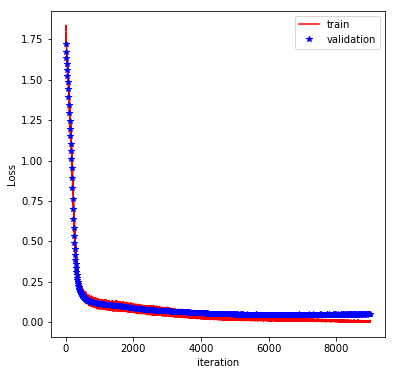

In [17]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

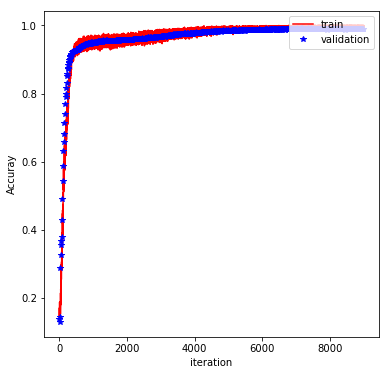

In [18]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [19]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.917500
